Hypothesis/Problem: The target variable is BABIP (batting average on balls in play), a measure of how often a player's batted balls (other than home runs) actually result in hits. I suspect it depends on the types of batted balls the player hits (so his percentage of ground balls, line drives, flyballs), his speed (which I will measure as stolen bases per plate appearances), and his age. I will also test power (measured as home runs per flyball) to see if that matters, but because home runs don't count as balls in play, it may not matter.

In [66]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
%matplotlib inline

In [103]:
df = pd.read_csv("../my_hw_repo/Fangraphs_2012.csv")
df2 = pd.read_csv("../my_hw_repo/Fangraphs_2013.csv")
df3 = pd.read_csv("../my_hw_repo/Fangraphs_2014.csv")
df4 = pd.read_csv("../my_hw_repo/Fangraphs_2015.csv")
df5 = pd.read_csv("../my_hw_repo/Fangraphs_2016.csv")

df.dtypes

Name         object
Age           int64
G             int64
PA            int64
2B            int64
3B            int64
HR            int64
SB            int64
CS            int64
BB%          object
K%           object
ISO         float64
BABIP       float64
AVG         float64
OBP         float64
SLG         float64
LD%          object
GB%          object
FB%          object
HR/FB        object
playerid      int64
dtype: object

In [104]:
batters = df.append(df2).append(df3).append(df4).append(df5)
#Combined 2012-2016 data into one dataframe called "batters"

batters = batters[["Age", "PA", "SB", "BABIP", "GB%", "LD%", "HR/FB"]]
#Kept the features I think may be relevant

batters['GB%'] = batters['GB%'].apply(lambda x: x[0:3]).astype(float)/100
batters['LD%'] = batters['LD%'].apply(lambda x: x[0:3]).astype(float)/100
batters['HR/FB'] = batters['HR/FB'].apply(lambda x: x[0:3]).astype(float)/100
#Converted the strings to floats, confirmed below by showing data types

batters.dtypes

Age        int64
PA         int64
SB         int64
BABIP    float64
GB%      float64
LD%      float64
HR/FB    float64
dtype: object

In [105]:
batters = batters[batters['PA'] > 200]
#Delete entries with low number of Plate Appearances that skew - using min. 200 PA gets mean BABIP to about .300,
#which is about what mean BABIP actually was over the period.

batters.describe().round(3)

,Age,PA,SB,BABIP,GB%,LD%,HR/FB
count,1753.000,1753.000,1753.000,1753.000,1753.000,1753.000,1753.000
mean,28.547,448.881,7.087,0.301,0.439,0.205,0.108
std,3.984,153.916,9.271,0.037,0.068,0.031,0.058
min,19.000,201.000,0.000,0.185,0.190,0.120,0.000
25%,26.000,311.000,1.000,0.275,0.390,0.190,0.066
50%,28.000,446.000,4.000,0.301,0.430,0.210,0.100
75%,31.000,586.000,10.000,0.324,0.480,0.220,0.140
max,42.000,744.000,64.000,0.411,0.670,0.310,0.400


In [106]:
batters['SB'] = batters['SB']/batters['PA'] #Change from raw SB totals to SB/PA - a proxy for speed
batters = batters[["Age", "SB", "BABIP", "GB%", "LD%", "HR/FB"]] #Deleted PA variable, not relevant anymore
batters.rename(columns = {'SB':'SBperPA', 'GB%':'GB', 'LD%':'LD', 'HR/FB':'HRperFB'}, inplace = True)
#Renamed columns for various reasons - mostly so they can be used later without % or / characters in them

batters.describe().round(3)

,Age,SBperPA,BABIP,GB,LD,HRperFB
count,1753.000,1753.000,1753.000,1753.000,1753.000,1753.000
mean,28.547,0.015,0.301,0.439,0.205,0.108
std,3.984,0.019,0.037,0.068,0.031,0.058
min,19.000,0.000,0.185,0.190,0.120,0.000
25%,26.000,0.003,0.275,0.390,0.190,0.066
50%,28.000,0.009,0.301,0.430,0.210,0.100
75%,31.000,0.021,0.324,0.480,0.220,0.140
max,42.000,0.142,0.411,0.670,0.310,0.400


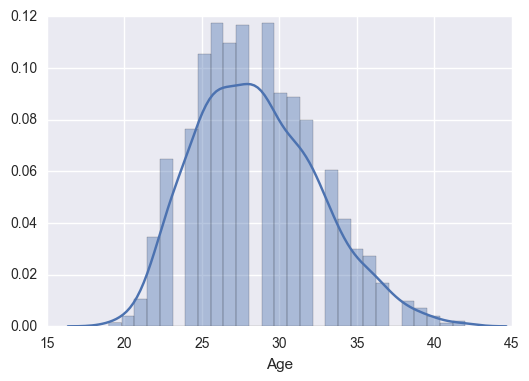

In [107]:
import seaborn as sns
sns.distplot(batters.Age);

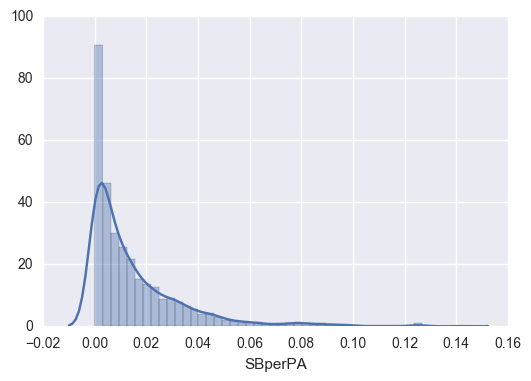

In [108]:
sns.distplot(batters.SBperPA);

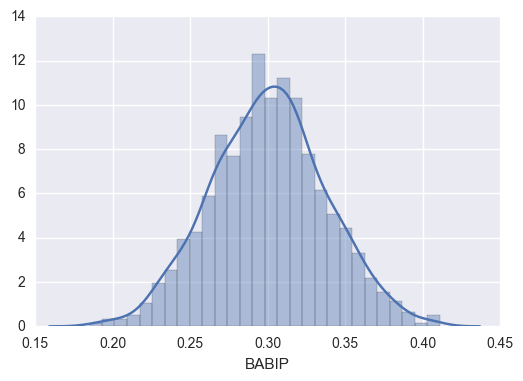

In [109]:
sns.distplot(batters.BABIP);

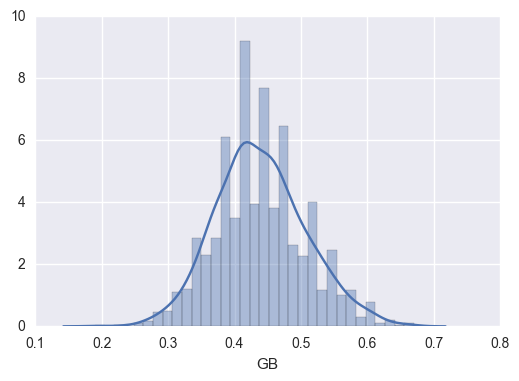

In [110]:
sns.distplot(batters.GB);

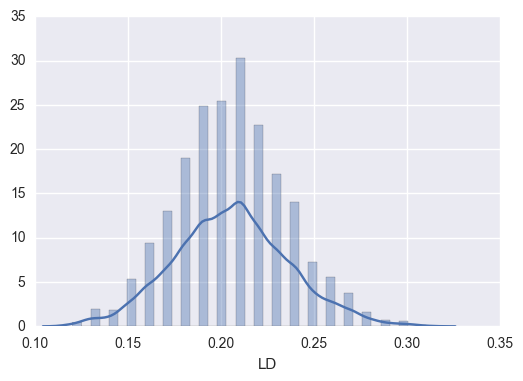

In [111]:
sns.distplot(batters.LD);

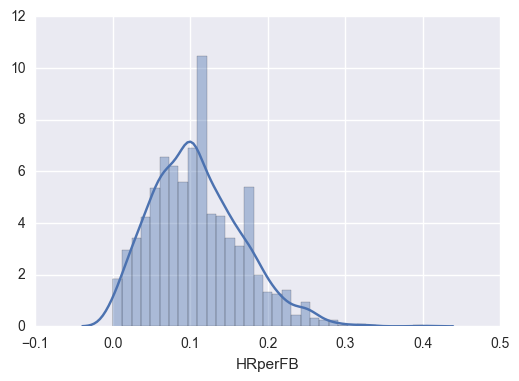

In [112]:
sns.distplot(batters.HRperFB);

In [113]:
from scipy.stats import normaltest
normaltest(batters['BABIP'])

NormaltestResult(statistic=0.50096138331338003, pvalue=0.77842650999493812)

In [114]:
normaltest(batters['Age'])

NormaltestResult(statistic=51.638709046013048, pvalue=6.1206395513692963e-12)

In [115]:
normaltest(batters['GB'])

NormaltestResult(statistic=15.853405291408516, pvalue=0.00036097471425328989)

In [116]:
normaltest(batters['LD'])

NormaltestResult(statistic=5.1826468396152254, pvalue=0.074920822745887392)

In [117]:
normaltest(batters['SBperPA'])

NormaltestResult(statistic=880.70680282462297, pvalue=5.7140979315808943e-192)

In [118]:
normaltest(batters['HRperFB'])

NormaltestResult(statistic=95.960536961181489, pvalue=1.4535640008562025e-21)

Note: Only BABIP and LD% are approximately normally distributed.

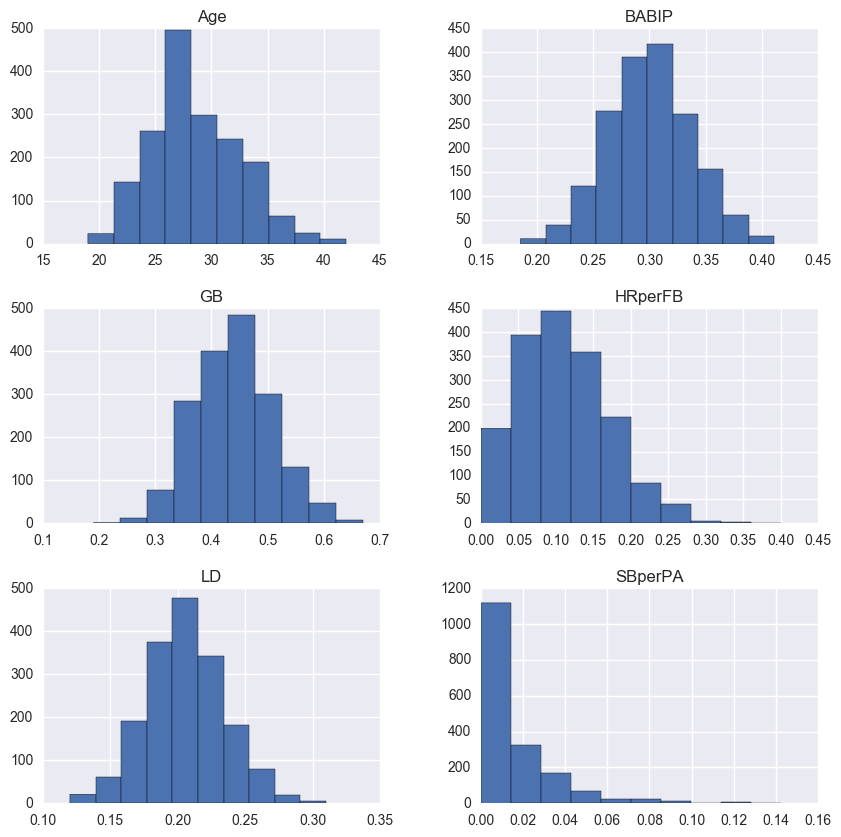

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
batters.hist(ax=ax);

Note: Both HRperFB (power) and SBperPA (speed) are skewed left

In [120]:
batters.corr()

,Age,SBperPA,BABIP,GB,LD,HRperFB
Age,1.000000,-0.159396,-0.186640,-0.074945,0.033582,-0.035524
SBperPA,-0.159396,1.000000,0.231881,0.315124,0.026725,-0.241681
BABIP,-0.186640,0.231881,1.000000,0.181572,0.445199,0.075564
GB,-0.074945,0.315124,0.181572,1.000000,-0.176134,-0.282338
LD,0.033582,0.026725,0.445199,-0.176134,1.000000,-0.127063
HRperFB,-0.035524,-0.241681,0.075564,-0.282338,-0.127063,1.000000


Note: The strongest correlation of features appears to be GB% and SBperPA - probably because faster players are more willing to hit the ball on the ground in order to try to get hits

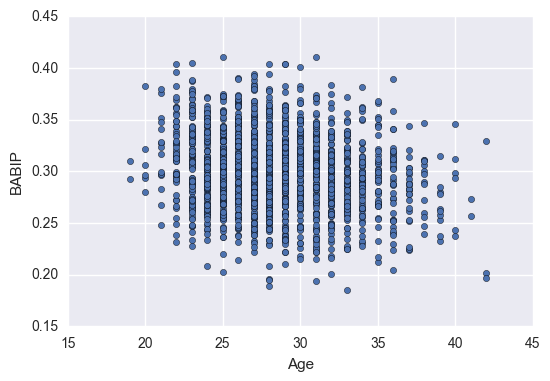

In [121]:
ax = batters.plot.scatter(x='Age', y='BABIP');

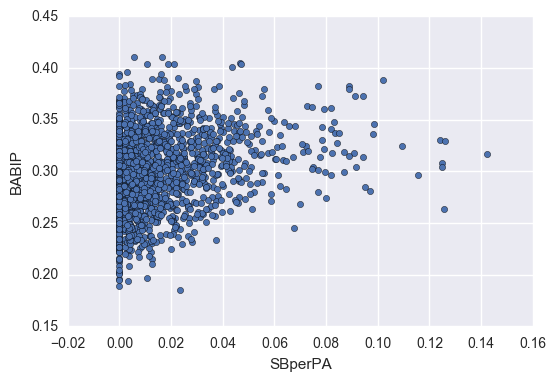

In [122]:
ax = batters.plot.scatter(x='SBperPA', y='BABIP');

Note: This, plus the skew of SBperPA as seen from the histogram, makes it seem necessary to standardize SBperPA

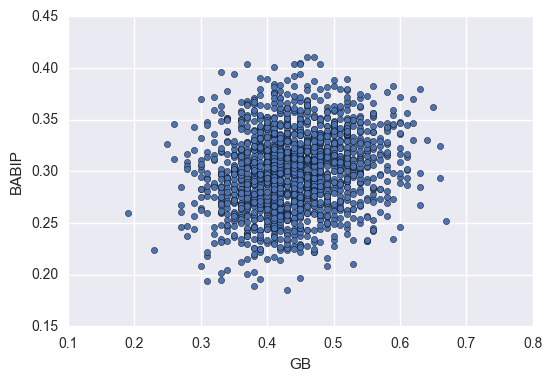

In [123]:
ax = batters.plot.scatter(x='GB', y='BABIP');

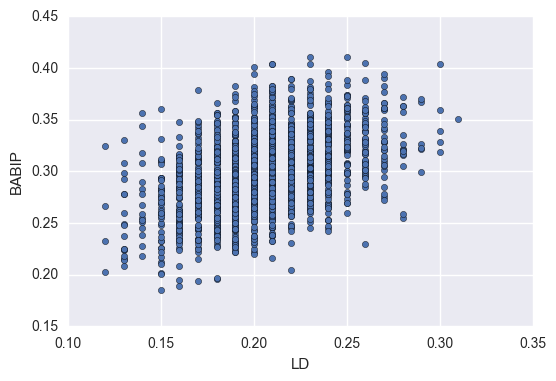

In [124]:
ax = batters.plot.scatter(x='LD', y='BABIP');

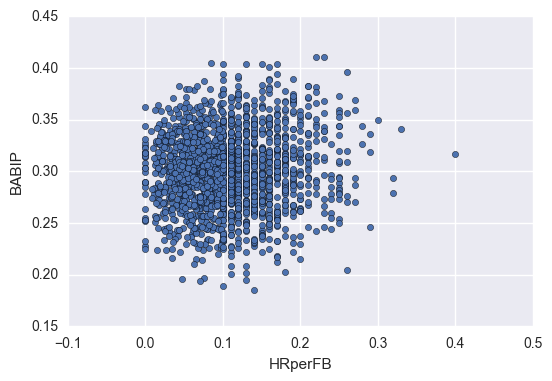

In [125]:
ax = batters.plot.scatter(x='HRperFB', y='BABIP');

Conclusions and Next Steps: At a glance, BABIP looks like it increases with Line-drive% (LD) and, to a lesser extent, speed (SBperPA) and Ground-ball% (GB%). Those two are correlated with each other, so I may want to just use one, perhaps GB% which isn't as skewed. BABIP also appears to decrease with Age. Power (HRperFB) is not normal, skewed, and doesn't appear to be correlated, so it may not need to be included. 

A lot of these variables are not normal, and they may need to be log transformed. Can I do this just for individual variables?

SBperPA and HRperFB are skewed left (since so many are close to zero). If I log transform these, I'll need to also standardize them. Do I standardize first, or log transform first? 

After the necessary transformations, I will run cross-validated linear regression on all the variables, and also on all minus HR per FB, and all minus HR per FB and SB per PA (since that is correlated with GB%). I may also run a random forest regression and list feature importance.